In [6]:
# Built-in
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, TimeDistributed, GlobalAveragePooling2D, LSTM, Dense, Dropout
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scikit-learn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

In [7]:
# ============================================================
# BƯỚC 1: CHUẨN BỊ DATAFRAME TỪ ẢNH (FAKE / REAL)
# ============================================================

# Define the path to the dataset
base_path =  r'C:\Users\3\Desktop\Dataset\faceplus_processed_research_final_2_crop'
categories = ['fake', 'real']

# Initialize a list to hold data
data = []

# Process each category
for category in categories:
    category_path = os.path.join(base_path, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.jpg'):
            try:
                id_part, frame_part = filename.split('_frame_')
                id_ = id_part.split('_')[0]
                frame = frame_part.split('.')[0]
                data.append({
                    'filename': filename,
                    'path': os.path.join(category_path, filename),
                    'id': int(id_),
                    'frame': int(frame),
                    'label': category
                })
            except ValueError:
                continue

# Convert the data to a DataFrame
df = pd.DataFrame(data)

# Mapping label -> số
df['label_id'] = df['label'].map({'fake': 0, 'real': 1})

# Tạo video_key: id_label (mỗi video)
df['video_key'] = df['id'].astype(str) + "_" + df['label']

from collections import defaultdict

video_dict = defaultdict(list)
labels = {}

for _, row in df.iterrows():
    key = row['video_key']
    video_dict[key].append(row['path'])
    labels[key] = row['label_id']

In [8]:
df

,filename,path,id,frame,label,label_id,video_key
0,000_003_frame_0000.jpg,C:\Users\3\Desktop\Dataset\faceplus_processed_...,0,0,fake,0,0_fake
1,000_003_frame_0001.jpg,C:\Users\3\Desktop\Dataset\faceplus_processed_...,0,1,fake,0,0_fake
2,000_003_frame_0002.jpg,C:\Users\3\Desktop\Dataset\faceplus_processed_...,0,2,fake,0,0_fake
3,000_003_frame_0003.jpg,C:\Users\3\Desktop\Dataset\faceplus_processed_...,0,3,fake,0,0_fake
4,000_003_frame_0004.jpg,C:\Users\3\Desktop\Dataset\faceplus_processed_...,0,4,fake,0,0_fake
...,...,...,...,...,...,...,...
59803,999_frame_0025.jpg,C:\Users\3\Desktop\Dataset\faceplus_processed_...,999,25,real,1,999_real
59804,999_frame_0026.jpg,C:\Users\3\Desktop\Dataset\faceplus_processed_...,999,26,real,1,999_real
59805,999_frame_0027.jpg,C:\Users\3\Desktop\Dataset\faceplus_processed_...,999,27,real,1,999_real
59806,999_frame_0028.jpg,C:\Users\3\Desktop\Dataset\faceplus_processed_...,999,28,real,1,999_real


In [9]:
# ============================================================
# BƯỚC 2: ĐỌC CSV FUSION: FFT + DCT + SRM + OPENFACE
# THAY THẾ CHO CSV OPENFACE CŨ
# ============================================================

print("📂 Loading pre-extracted OpenFace features from CSV files...")

# ĐƯỜNG DẪN FUSION CSV (fake / real)
csv_fake_path = r'C:\Users\3\Desktop\Dataset\Fusion-frequency-openface-FF\merge_frequency_openface_features_fake_FFDataset.csv'
csv_real_path = r'C:\Users\3\Desktop\Dataset\Fusion-frequency-openface-FF\merge_frequency_openface_features_real_FFDataset.csv'

# Kiểm tra tồn tại
if not os.path.exists(csv_fake_path):
    raise FileNotFoundError(f"Không tìm thấy file: {csv_fake_path}")
if not os.path.exists(csv_real_path):
    raise FileNotFoundError(f"Không tìm thấy file: {csv_real_path}")

# Đọc CSV có header
df_fake_features = pd.read_csv(csv_fake_path)
df_real_features = pd.read_csv(csv_real_path)

# Gộp chung fake + real
df_all_features = pd.concat([df_fake_features, df_real_features], ignore_index=True)

# Đảm bảo cột đầu tiên là 'filename'
df_all_features.rename(columns={df_all_features.columns[0]: 'filename'}, inplace=True)

# Các cột metadata KHÔNG đưa vào vector feature
non_feature_cols = [
    'filename',
    'width', 'height', 'color_mode', 'resize_to', 'do_hann'
]
non_feature_cols = [c for c in non_feature_cols if c in df_all_features.columns]

# Tất cả cột còn lại là feature: SRM + DCT + FFT + OpenFace (feature_1..feature_674,...)
feature_cols = [c for c in df_all_features.columns if c not in non_feature_cols]

# Tạo dict: filename -> vector feature (fusion)
openface_features = {}
for _, row in df_all_features.iterrows():
    filename = row['filename']
    features = row[feature_cols].values.astype('float32')
    openface_features[filename] = features

# Số chiều vector feature fusion
csv_feature_dim = len(feature_cols)

print(f"✅ Loaded {len(openface_features)} feature vectors")
print(f"✅ Each vector has {csv_feature_dim} dimensions")
print(f"✅ Feature dictionary ready for 1-to-1 frame mapping")

📂 Loading pre-extracted OpenFace features from CSV files...
✅ Loaded 59808 feature vectors
✅ Each vector has 952 dimensions
✅ Feature dictionary ready for 1-to-1 frame mapping


In [10]:
# ============================================================
# BƯỚC 3: CẤU HÌNH MÔ HÌNH + TRAINING (TCN + MobileNetV2)
# ============================================================

import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (
    Input, TimeDistributed, Dropout, Dense, GlobalAveragePooling2D, 
    Concatenate, BatchNormalization, Conv1D, Add, Activation, LayerNormalization, GlobalAveragePooling1D
    )
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from hmmlearn.hmm import GaussianHMM
from scipy.stats import mode
from sklearn.preprocessing import StandardScaler

# Configuration - Enhanced
video_keys = list(video_dict.keys())
video_labels = [labels[k] for k in video_keys]

img_size = (224, 224)
batch_size = 16   # Reduced for better generalization
epochs = 100      # Increased for better convergence
n_splits = 5
sequence_len = 15 # Increased to capture more temporal information
results = []
all_histories = []


In [11]:
# ============================================================
# BƯỚC 4: NORMALIZE CSV FEATURES (FUSION) VỚI STANDARD SCALER
# ============================================================

print("🔧 Computing CSV feature statistics for normalization...")
all_csv_features = []
for key in video_keys:
    frames = video_dict[key][:sequence_len]
    for path in frames:
        filename = os.path.basename(path)
        if filename in openface_features:
            all_csv_features.append(openface_features[filename])

# Debug: Check if we have any features
print(f"📊 Found {len(all_csv_features)} CSV features from {len(video_keys)} videos")
if len(all_csv_features) == 0:
    print("⚠️ WARNING: No matching CSV features found!")
    print(f"   Sample video filename: {os.path.basename(list(video_dict.values())[0][0])}")
    print(f"   Sample CSV key: {list(openface_features.keys())[0]}")
    raise ValueError("No CSV features found - check filename matching!")

csv_scaler = StandardScaler()
csv_scaler.fit(np.array(all_csv_features))  # Convert to numpy array
print(f"✅ CSV feature normalization fitted on {len(all_csv_features)} samples")

🔧 Computing CSV feature statistics for normalization...
📊 Found 29964 CSV features from 2000 videos
✅ CSV feature normalization fitted on 29964 samples


In [12]:
# ============================================================
# BƯỚC 5: DATA GENERATOR CHO VIDEO + CSV FUSION
# ============================================================

class VideoSequence(tf.keras.utils.Sequence):
    def __init__(self, video_keys, video_dict, labels, batch_size, img_size, sequence_len=15, augment=False):
        self.video_keys = video_keys
        self.video_dict = video_dict
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.sequence_len = sequence_len
        self.augment = augment
        # Enhanced augmentation for better regularization
        self.datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20 if augment else 0,
            width_shift_range=0.15 if augment else 0,
            height_shift_range=0.15 if augment else 0,
            zoom_range=0.15 if augment else 0,
            horizontal_flip=augment,
            brightness_range=[0.8, 1.2] if augment else None,
            fill_mode='nearest'
        )

    def __len__(self):
        return int(np.ceil(len(self.video_keys) / self.batch_size))

    def __getitem__(self, idx):
        batch_keys = self.video_keys[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X_img, batch_X_csv, batch_y = [], [], []

        for key in batch_keys:
            frames = self.video_dict[key][:self.sequence_len]
            imgs = []
            csv_feats = []
            
            for path in frames:
                # Load and process image
                img = cv2.imread(path)
                img = cv2.resize(img, self.img_size)
                img = self.datagen.random_transform(img) if self.augment else img
                img = img.astype('float32') / 255.0
                imgs.append(img)
                
                # Load CSV features and normalize (1-to-1 mapping)
                filename = os.path.basename(path)
                if filename in openface_features:
                    csv_feat = openface_features[filename]
                    csv_feat = csv_scaler.transform(csv_feat.reshape(1, -1))[0]
                else:
                    csv_feat = np.zeros(csv_feature_dim, dtype='float32')
                csv_feats.append(csv_feat)
            
            # Pad sequences if needed
            while len(imgs) < self.sequence_len:
                imgs.append(np.zeros((*self.img_size, 3), dtype='float32'))
                csv_feats.append(np.zeros(csv_feature_dim, dtype='float32'))
            
            batch_X_img.append(imgs)
            batch_X_csv.append(csv_feats)
            batch_y.append(self.labels[key])

        return [np.array(batch_X_img), np.array(batch_X_csv)], np.array(batch_y)


In [13]:
# ============================================================
# BƯỚC 6: ĐỊNH NGHĨA KHỐI TCN RESIDUAL
# ============================================================

def tcn_residual_block(x, filters, kernel_size, dilation_rate, block_num):
    shortcut = x
    # First convolutional layer
    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, name=f'tcn_conv_{block_num}_1')(x)
    x = LayerNormalization(name=f'tcn_ln_{block_num}_1')(x)
    x = Activation('relu', name=f'tcn_relu_{block_num}_1')(x)
    x = Dropout(0.3, name=f'tcn_dropout_{block_num}_1')(x)
    
    # Second convolutional layer
    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, name=f'tcn_conv_{block_num}_2')(x)
    x = LayerNormalization(name=f'tcn_ln_{block_num}_2')(x)
    x = Activation('relu', name=f'tcn_relu_{block_num}_2')(x)
    x = Dropout(0.3, name=f'tcn_dropout_{block_num}_2')(x)
    
    # Residual connection with projection if needed
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding='same', name=f'tcn_shortcut_{block_num}')(shortcut)
    
    x = Add(name=f'tcn_add_{block_num}')([x, shortcut])
    x = Activation('relu', name=f'tcn_out_relu_{block_num}')(x)
    return x

# ============================================================
# BƯỚC 7: XÂY DỰNG MÔ HÌNH TCN + MOBILENETV2 + CSV FUSION
# ============================================================

def build_model(sequence_len, img_size, csv_dim=674):
    # MobileNet branch with more trainable layers
    base_cnn = MobileNetV2(input_shape=(*img_size, 3), include_top=False, weights='imagenet')
    base_cnn.trainable = True
    # Fine-tune more layers for better feature extraction
    for layer in base_cnn.layers[:-30]:
        layer.trainable = False
    
    cnn_out = GlobalAveragePooling2D()(base_cnn.output)
    cnn_model = Model(inputs=base_cnn.input, outputs=cnn_out)
    
    # Image sequence input
    input_seq_img = Input(shape=(sequence_len, *img_size, 3), name='image_input')
    x_img = TimeDistributed(cnn_model)(input_seq_img)
    
    # CSV features input
    input_seq_csv = Input(shape=(sequence_len, csv_dim), name='csv_input')
    
    # BatchNormalization before fusion
    x_img = BatchNormalization(name='bn_mobilenet')(x_img)
    x_csv = BatchNormalization(name='bn_csv')(input_seq_csv)
    
    # Concatenate features (1-to-1 fusion)
    x_combined = Concatenate(axis=-1, name='feature_fusion')([x_img, x_csv])
    
    # Enhanced TCN blocks with increased capacity (256 filters)
    # Using dilations: 1, 2, 4, 8, 16, 32 for deeper temporal receptive field
    x = x_combined
    tcn_configs = [
        (256, 3, 1),   # dilation=1
        (256, 3, 2),   # dilation=2
        (256, 3, 4),   # dilation=4
        (256, 3, 8),   # dilation=8
        (128, 3, 16),  # dilation=16, reduced filters
        (128, 3, 32),  # dilation=32, reduced filters
    ]
    
    for i, (filters, kernel_size, dilation_rate) in enumerate(tcn_configs):
        x = tcn_residual_block(x, filters, kernel_size, dilation_rate, i+1)
    
    # Global average pooling over time dimension
    x = GlobalAveragePooling1D(name='global_avg_pool')(x)
    x = Dropout(0.3, name='dropout_global')(x)
    
    # Enhanced classification layers with more capacity
    x = Dense(128, activation='relu', name='dense_1')(x)
    x = BatchNormalization(name='bn_dense_1')(x)
    x = Dropout(0.4, name='dropout_3')(x)
    
    x = Dense(64, activation='relu', name='dense_2')(x)
    x = BatchNormalization(name='bn_dense_2')(x)
    x = Dropout(0.3, name='dropout_4')(x)
    
    output = Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=[input_seq_img, input_seq_csv], outputs=output, name='TCN_Residual_Enhanced')
    return model

# ============================================================
# BƯỚC 8: HMM POST-PROCESSING
# ============================================================

def hmm_postprocess(pred_probs, y_true, n_states=2):
    pred_probs = pred_probs.reshape(-1, 1)
    hmm = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100)
    hmm.fit(pred_probs)
    hidden_states = hmm.predict(pred_probs)

    mapping = {}
    for state in np.unique(hidden_states):
        indices = [i for i in range(len(hidden_states)) if hidden_states[i] == state]
        state_labels = [y_true[i] for i in indices]
        if len(state_labels) > 0:
            mapped_label = mode(state_labels, keepdims=True).mode[0]
        else:
            mapped_label = 0
        mapping[state] = mapped_label

    hmm_labels = np.array([mapping[s] for s in hidden_states])
    return hmm_labels

# ============================================================
# BƯỚC 9: TRAINING VỚI K-FOLD CROSS-VALIDATION
# ============================================================

print("\n🚀 Starting Enhanced TCN + Residual Blocks Training:")
print("   ✅ TCN (6 blocks, dilations: 1/2/4/8/16/32)")
print("   ✅ Increased filters: 256 → 256 → 256 → 256 → 128 → 128")
print("   ✅ Layer Normalization after each conv layer")
print("   ✅ Enhanced data augmentation")
print("   ✅ Sequence length: 15 frames")
print("   ✅ MobileNet (last 30 layers trainable)")
print("   ✅ Stronger regularization (dropout 0.3-0.4)")
print("   ✅ HMM post-processing\n")

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (trainval_idx, test_idx) in enumerate(skf.split(video_keys, video_labels), 1):
    print(f"\n{'='*60}")
    print(f"📊 Fold {fold}/{n_splits} - Enhanced TCN_Residual")
    print(f"{'='*60}")

    trainval_keys = [video_keys[i] for i in trainval_idx]
    test_keys = [video_keys[i] for i in test_idx]

    y_trainval = [labels[k] for k in trainval_keys]
    train_keys, val_keys = train_test_split(trainval_keys, test_size=0.15, stratify=y_trainval, random_state=fold)

    train_gen = VideoSequence(train_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=True)
    val_gen = VideoSequence(val_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)
    test_gen = VideoSequence(test_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)

    model = build_model(sequence_len, img_size, csv_feature_dim)
    
    # Enhanced optimizer with learning rate
    initial_lr = 1e-4
    model.compile(
        optimizer=Adamax(learning_rate=initial_lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    print(f"\n📈 Enhanced Model Architecture:")
    print(f"   - Model: TCN (6 blocks, 256+256+256+256+128+128 filters)")
    print(f"   - Total params: {model.count_params():,}")
    trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
    print(f"   - Trainable params: {trainable_params:,}")
    print(f"   - Sequence length: {sequence_len}")
    print(f"   - Batch size: {batch_size}")
    print(f"   - Initial learning rate: {initial_lr}")

    model_path = f"best_model_fold{fold}_tcn_res_enhanced.h5"
    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    earlystop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[checkpoint, earlystop, reduce_lr],
        verbose=1
    )
    all_histories.append(history.history)

    # Load best weights
    model.load_weights(model_path)

    # Evaluate
    y_true = [labels[k] for k in test_keys]
    y_pred_prob = model.predict(test_gen).ravel()
    y_hmm_pred = hmm_postprocess(y_pred_prob, y_true)

    results.append({
        'fold': fold,
        'accuracy': accuracy_score(y_true, y_hmm_pred),
        'precision': precision_score(y_true, y_hmm_pred),
        'recall': recall_score(y_true, y_hmm_pred),
        'f1': f1_score(y_true, y_hmm_pred),
        'auc': roc_auc_score(y_true, y_pred_prob)
    })
    
    print(f"\n✅ Fold {fold} Results (Enhanced TCN_Residual):")
    print(f"   Accuracy:  {results[-1]['accuracy']:.4f}")
    print(f"   Precision: {results[-1]['precision']:.4f}")
    print(f"   Recall:    {results[-1]['recall']:.4f}")
    print(f"   F1 Score:  {results[-1]['f1']:.4f}")
    print(f"   AUC:       {results[-1]['auc']:.4f}")

print(f"\n{'='*60}")
print("📊 FINAL RESULTS - Enhanced TCN_Residual Model")
print(f"{'='*60}")
for r in results:
    print(f"Fold {r['fold']}: Acc={r['accuracy']:.4f}, Prec={r['precision']:.4f}, Rec={r['recall']:.4f}, F1={r['f1']:.4f}, AUC={r['auc']:.4f}")

print(f"\n📊 Average Metrics:")
results_df = pd.DataFrame(results)
print(results_df.mean(numeric_only=True))

# Calculate CV metrics
accuracy_mean = results_df['accuracy'].mean()
accuracy_std = results_df['accuracy'].std()
accuracy_range = results_df['accuracy'].max() - results_df['accuracy'].min()
accuracy_cv_percent = (accuracy_std / accuracy_mean) * 100

print(f"\n📈 Cross-Validation Stability:")
print(f"   Mean Accuracy: {accuracy_mean:.4f}")
print(f"   Std Deviation: {accuracy_std:.4f}")
print(f"   Range: {accuracy_range:.4f}")
print(f"   CV%: {accuracy_cv_percent:.2f}%")


🚀 Starting Enhanced TCN + Residual Blocks Training:
   ✅ TCN (6 blocks, dilations: 1/2/4/8/16/32)
   ✅ Increased filters: 256 → 256 → 256 → 256 → 128 → 128
   ✅ Layer Normalization after each conv layer
   ✅ Enhanced data augmentation
   ✅ Sequence length: 15 frames
   ✅ MobileNet (last 30 layers trainable)
   ✅ Stronger regularization (dropout 0.3-0.4)
   ✅ HMM post-processing


📊 Fold 1/5 - Enhanced TCN_Residual



📈 Enhanced Model Architecture:
   - Model: TCN (6 blocks, 256+256+256+256+128+128 filters)
   - Total params: 6,240,929
   - Trainable params: 5,504,497
   - Sequence length: 15
   - Batch size: 16
   - Initial learning rate: 0.0001
Epoch 1/100


85/85 [==============================] - ETA: 0s - loss: 0.9085 - accuracy: 0.5279
Epoch 1: val_accuracy improved from -inf to 0.53333, saving model to best_model_fold1_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 404s 5s/step - loss: 0.9085 - accuracy: 0.5279 - val_loss: 0.7350 - val_accuracy: 0.5333 - lr: 1.0000e-04
Epoch 2/100
85/85 [==============================] - ETA: 0s - loss: 0.8634 - accuracy: 0.5699
Epoch 2: val_accuracy improved from 0.53333 to 0.68333, saving model to best_model_fold1_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 380s 4s/step - loss: 0.8634 - accuracy: 0.5699 - val_loss: 0.6046 - val_accuracy: 0.6833 - lr: 1.0000e-04
Epoch 3/100
85/85 [==============================] - ETA: 0s - loss: 0.8134 - accuracy: 0.5978
Epoch 3: val_accuracy improved from 0.68333 to 0.71250, saving model to best_model_fold1_tcn_res_enhanced.h5
85/85 [==============================] - 378s 4s/step - loss: 0.8134 - accuracy: 0.5978 - val_loss: 0.5700 - val_accuracy: 0.7125 - lr: 1.0000e-04


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 4/100
85/85 [==============================] - ETA: 0s - loss: 0.7349 - accuracy: 0.6250
Epoch 4: val_accuracy did not improve from 0.71250
85/85 [==============================] - 377s 4s/step - loss: 0.7349 - accuracy: 0.6250 - val_loss: 0.5744 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 5/100
85/85 [==============================] - ETA: 0s - loss: 0.7597 - accuracy: 0.6147
Epoch 5: val_accuracy did not improve from 0.71250
85/85 [==============================] - 376s 4s/step - loss: 0.7597 - accuracy: 0.6147 - val_loss: 0.5720 - val_accuracy: 0.6958 - lr: 1.0000e-04
Epoch 6/100
85/85 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.6551
Epoch 6: val_accuracy did not improve from 0.71250
85/85 [==============================] - 375s 4s/step - loss: 0.6942 - accuracy: 0.6551 - val_loss: 0.5549 - val_accuracy: 0.7083 - lr: 1.0000e-04
Epoch 7/100
85/85 [==============================] - ETA: 0s - loss: 0.6574 - accuracy: 0.6890
Epoch 7: val_accuracy impr

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 375s 4s/step - loss: 0.6574 - accuracy: 0.6890 - val_loss: 0.5884 - val_accuracy: 0.7167 - lr: 1.0000e-04
Epoch 8/100
85/85 [==============================] - ETA: 0s - loss: 0.6446 - accuracy: 0.6934
Epoch 8: val_accuracy did not improve from 0.71667
85/85 [==============================] - 376s 4s/step - loss: 0.6446 - accuracy: 0.6934 - val_loss: 0.6237 - val_accuracy: 0.7083 - lr: 1.0000e-04
Epoch 9/100
85/85 [==============================] - ETA: 0s - loss: 0.6052 - accuracy: 0.7140
Epoch 9: val_accuracy did not improve from 0.71667
85/85 [==============================] - 375s 4s/step - loss: 0.6052 - accuracy: 0.7140 - val_loss: 0.6345 - val_accuracy: 0.7125 - lr: 1.0000e-04
Epoch 10/100
85/85 [==============================] - ETA: 0s - loss: 0.5635 - accuracy: 0.7301
Epoch 10: val_accuracy improved from 0.71667 to 0.73750, saving model to best_model_fold1_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 375s 4s/step - loss: 0.5635 - accuracy: 0.7301 - val_loss: 0.6538 - val_accuracy: 0.7375 - lr: 1.0000e-04
Epoch 11/100
85/85 [==============================] - ETA: 0s - loss: 0.5052 - accuracy: 0.7544
Epoch 11: val_accuracy improved from 0.73750 to 0.77083, saving model to best_model_fold1_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 11: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
85/85 [==============================] - 379s 4s/step - loss: 0.5052 - accuracy: 0.7544 - val_loss: 0.6189 - val_accuracy: 0.7708 - lr: 1.0000e-04
Epoch 12/100
85/85 [==============================] - ETA: 0s - loss: 0.4697 - accuracy: 0.7971
Epoch 12: val_accuracy improved from 0.77083 to 0.77917, saving model to best_model_fold1_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 390s 5s/step - loss: 0.4697 - accuracy: 0.7971 - val_loss: 0.5826 - val_accuracy: 0.7792 - lr: 5.0000e-05
Epoch 13/100
85/85 [==============================] - ETA: 0s - loss: 0.4969 - accuracy: 0.7824
Epoch 13: val_accuracy improved from 0.77917 to 0.78750, saving model to best_model_fold1_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 376s 4s/step - loss: 0.4969 - accuracy: 0.7824 - val_loss: 0.5083 - val_accuracy: 0.7875 - lr: 5.0000e-05
Epoch 14/100
85/85 [==============================] - ETA: 0s - loss: 0.4680 - accuracy: 0.7985
Epoch 14: val_accuracy did not improve from 0.78750
85/85 [==============================] - 377s 4s/step - loss: 0.4680 - accuracy: 0.7985 - val_loss: 0.5247 - val_accuracy: 0.7875 - lr: 5.0000e-05
Epoch 15/100
85/85 [==============================] - ETA: 0s - loss: 0.4485 - accuracy: 0.7919
Epoch 15: val_accuracy did not improve from 0.78750
85/85 [==============================] - 377s 4s/step - loss: 0.4485 - accuracy: 0.7919 - val_loss: 0.5240 - val_accuracy: 0.7833 - lr: 5.0000e-05
Epoch 16/100
85/85 [==============================] - ETA: 0s - loss: 0.4281 - accuracy: 0.8022
Epoch 16: val_accuracy improved from 0.78750 to 0.80833, saving model to best_model_fold1_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 497s 6s/step - loss: 0.4281 - accuracy: 0.8022 - val_loss: 0.4654 - val_accuracy: 0.8083 - lr: 5.0000e-05
Epoch 17/100
85/85 [==============================] - ETA: 0s - loss: 0.4140 - accuracy: 0.8206
Epoch 17: val_accuracy improved from 0.80833 to 0.84167, saving model to best_model_fold1_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 453s 5s/step - loss: 0.4140 - accuracy: 0.8206 - val_loss: 0.4282 - val_accuracy: 0.8417 - lr: 5.0000e-05
Epoch 18/100
85/85 [==============================] - ETA: 0s - loss: 0.3733 - accuracy: 0.8316
Epoch 18: val_accuracy improved from 0.84167 to 0.85417, saving model to best_model_fold1_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 406s 5s/step - loss: 0.3733 - accuracy: 0.8316 - val_loss: 0.3961 - val_accuracy: 0.8542 - lr: 5.0000e-05
Epoch 19/100
85/85 [==============================] - ETA: 0s - loss: 0.3896 - accuracy: 0.8338
Epoch 19: val_accuracy improved from 0.85417 to 0.87083, saving model to best_model_fold1_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 405s 5s/step - loss: 0.3896 - accuracy: 0.8338 - val_loss: 0.3899 - val_accuracy: 0.8708 - lr: 5.0000e-05
Epoch 20/100
85/85 [==============================] - ETA: 0s - loss: 0.3764 - accuracy: 0.8346
Epoch 20: val_accuracy did not improve from 0.87083
85/85 [==============================] - 404s 5s/step - loss: 0.3764 - accuracy: 0.8346 - val_loss: 0.3997 - val_accuracy: 0.8625 - lr: 5.0000e-05
Epoch 21/100
85/85 [==============================] - ETA: 0s - loss: 0.3557 - accuracy: 0.8507
Epoch 21: val_accuracy did not improve from 0.87083
85/85 [==============================] - 404s 5s/step - loss: 0.3557 - accuracy: 0.8507 - val_loss: 0.3855 - val_accuracy: 0.8625 - lr: 5.0000e-05
Epoch 22/100
85/85 [==============================] - ETA: 0s - loss: 0.3392 - accuracy: 0.8632
Epoch 22: val_accuracy did not improve from 0.87083
85/85 [==============================] - 400s 5s/step - loss: 0.3392 - accuracy: 0.8632 - val_loss: 0.3971 - val_ac

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 398s 5s/step - loss: 0.9442 - accuracy: 0.5265 - val_loss: 0.5934 - val_accuracy: 0.7208 - lr: 1.0000e-04
Epoch 2/100
85/85 [==============================] - ETA: 0s - loss: 0.8134 - accuracy: 0.5971
Epoch 2: val_accuracy did not improve from 0.72083
85/85 [==============================] - 387s 5s/step - loss: 0.8134 - accuracy: 0.5971 - val_loss: 0.6098 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 3/100
85/85 [==============================] - ETA: 0s - loss: 0.7650 - accuracy: 0.6176
Epoch 3: val_accuracy did not improve from 0.72083
85/85 [==============================] - 379s 4s/step - loss: 0.7650 - accuracy: 0.6176 - val_loss: 0.5759 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 4/100
85/85 [==============================] - ETA: 0s - loss: 0.7486 - accuracy: 0.6375
Epoch 4: val_accuracy did not improve from 0.72083
85/85 [==============================] - 378s 4s/step - loss: 0.7486 - accuracy: 0.6375 - val_loss: 0.5362 - val_accuracy

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 377s 4s/step - loss: 0.6013 - accuracy: 0.7221 - val_loss: 0.5152 - val_accuracy: 0.7583 - lr: 1.0000e-04
Epoch 7/100
85/85 [==============================] - ETA: 0s - loss: 0.5860 - accuracy: 0.7353
Epoch 7: val_accuracy did not improve from 0.75833
85/85 [==============================] - 380s 4s/step - loss: 0.5860 - accuracy: 0.7353 - val_loss: 0.5401 - val_accuracy: 0.7417 - lr: 1.0000e-04
Epoch 8/100
85/85 [==============================] - ETA: 0s - loss: 0.5772 - accuracy: 0.7184
Epoch 8: val_accuracy did not improve from 0.75833
85/85 [==============================] - 380s 4s/step - loss: 0.5772 - accuracy: 0.7184 - val_loss: 0.5629 - val_accuracy: 0.7458 - lr: 1.0000e-04
Epoch 9/100
85/85 [==============================] - ETA: 0s - loss: 0.5222 - accuracy: 0.7581
Epoch 9: val_accuracy did not improve from 0.75833
85/85 [==============================] - 376s 4s/step - loss: 0.5222 - accuracy: 0.7581 - val_loss: 0.5847 - val_accuracy

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 379s 4s/step - loss: 0.5147 - accuracy: 0.7706 - val_loss: 0.5025 - val_accuracy: 0.7833 - lr: 1.0000e-04
Epoch 11/100
85/85 [==============================] - ETA: 0s - loss: 0.4454 - accuracy: 0.7926
Epoch 11: val_accuracy improved from 0.78333 to 0.80833, saving model to best_model_fold2_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 379s 4s/step - loss: 0.4454 - accuracy: 0.7926 - val_loss: 0.5326 - val_accuracy: 0.8083 - lr: 1.0000e-04
Epoch 12/100
85/85 [==============================] - ETA: 0s - loss: 0.4319 - accuracy: 0.8074
Epoch 12: val_accuracy improved from 0.80833 to 0.83750, saving model to best_model_fold2_tcn_res_enhanced.h5
85/85 [==============================] - 379s 4s/step - loss: 0.4319 - accuracy: 0.8074 - val_loss: 0.4693 - val_accuracy: 0.8375 - lr: 1.0000e-04


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 13/100
85/85 [==============================] - ETA: 0s - loss: 0.4139 - accuracy: 0.8125
Epoch 13: val_accuracy did not improve from 0.83750
85/85 [==============================] - 379s 4s/step - loss: 0.4139 - accuracy: 0.8125 - val_loss: 0.4866 - val_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 14/100
85/85 [==============================] - ETA: 0s - loss: 0.3847 - accuracy: 0.8140
Epoch 14: val_accuracy did not improve from 0.83750
85/85 [==============================] - 384s 5s/step - loss: 0.3847 - accuracy: 0.8140 - val_loss: 0.4780 - val_accuracy: 0.8250 - lr: 1.0000e-04
Epoch 15/100
85/85 [==============================] - ETA: 0s - loss: 0.3479 - accuracy: 0.8566
Epoch 15: val_accuracy improved from 0.83750 to 0.84583, saving model to best_model_fold2_tcn_res_enhanced.h5
85/85 [==============================] - 390s 5s/step - loss: 0.3479 - accuracy: 0.8566 - val_loss: 0.4998 - val_accuracy: 0.8458 - lr: 1.0000e-04


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 16/100
85/85 [==============================] - ETA: 0s - loss: 0.3015 - accuracy: 0.8699
Epoch 16: val_accuracy improved from 0.84583 to 0.85833, saving model to best_model_fold2_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 380s 4s/step - loss: 0.3015 - accuracy: 0.8699 - val_loss: 0.3916 - val_accuracy: 0.8583 - lr: 1.0000e-04
Epoch 17/100
85/85 [==============================] - ETA: 0s - loss: 0.3034 - accuracy: 0.8728
Epoch 17: val_accuracy did not improve from 0.85833
85/85 [==============================] - 383s 4s/step - loss: 0.3034 - accuracy: 0.8728 - val_loss: 0.3726 - val_accuracy: 0.8583 - lr: 1.0000e-04
Epoch 18/100
85/85 [==============================] - ETA: 0s - loss: 0.2990 - accuracy: 0.8853
Epoch 18: val_accuracy did not improve from 0.85833
85/85 [==============================] - 378s 4s/step - loss: 0.2990 - accuracy: 0.8853 - val_loss: 0.4457 - val_accuracy: 0.8583 - lr: 1.0000e-04
Epoch 19/100
85/85 [==============================] - ETA: 0s - loss: 0.2840 - accuracy: 0.8757
Epoch 19: val_accuracy improved from 0.85833 to 0.87500, saving model to best_model_fold2_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 379s 4s/step - loss: 0.2840 - accuracy: 0.8757 - val_loss: 0.3896 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 20/100
85/85 [==============================] - ETA: 0s - loss: 0.2496 - accuracy: 0.9029
Epoch 20: val_accuracy did not improve from 0.87500
85/85 [==============================] - 378s 4s/step - loss: 0.2496 - accuracy: 0.9029 - val_loss: 0.3398 - val_accuracy: 0.8625 - lr: 1.0000e-04
Epoch 21/100
85/85 [==============================] - ETA: 0s - loss: 0.2156 - accuracy: 0.9132
Epoch 21: val_accuracy did not improve from 0.87500
85/85 [==============================] - 379s 4s/step - loss: 0.2156 - accuracy: 0.9132 - val_loss: 0.3933 - val_accuracy: 0.8708 - lr: 1.0000e-04
Epoch 22/100
85/85 [==============================] - ETA: 0s - loss: 0.2205 - accuracy: 0.9059
Epoch 22: val_accuracy did not improve from 0.87500
85/85 [==============================] - 379s 4s/step - loss: 0.2205 - accuracy: 0.9059 - val_loss: 0.4619 - val_ac

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 389s 4s/step - loss: 0.8796 - accuracy: 0.5588 - val_loss: 0.6180 - val_accuracy: 0.6542 - lr: 1.0000e-04
Epoch 2/100
85/85 [==============================] - ETA: 0s - loss: 0.8083 - accuracy: 0.6007
Epoch 2: val_accuracy improved from 0.65417 to 0.67083, saving model to best_model_fold3_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 383s 5s/step - loss: 0.8083 - accuracy: 0.6007 - val_loss: 0.5952 - val_accuracy: 0.6708 - lr: 1.0000e-04
Epoch 3/100
85/85 [==============================] - ETA: 0s - loss: 0.7294 - accuracy: 0.6279
Epoch 3: val_accuracy improved from 0.67083 to 0.68333, saving model to best_model_fold3_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 382s 4s/step - loss: 0.7294 - accuracy: 0.6279 - val_loss: 0.5783 - val_accuracy: 0.6833 - lr: 1.0000e-04
Epoch 4/100
85/85 [==============================] - ETA: 0s - loss: 0.6613 - accuracy: 0.6713
Epoch 4: val_accuracy improved from 0.68333 to 0.71667, saving model to best_model_fold3_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 381s 4s/step - loss: 0.6613 - accuracy: 0.6713 - val_loss: 0.5744 - val_accuracy: 0.7167 - lr: 1.0000e-04
Epoch 5/100
85/85 [==============================] - ETA: 0s - loss: 0.6409 - accuracy: 0.7015
Epoch 5: val_accuracy did not improve from 0.71667
85/85 [==============================] - 380s 4s/step - loss: 0.6409 - accuracy: 0.7015 - val_loss: 0.5977 - val_accuracy: 0.6917 - lr: 1.0000e-04
Epoch 6/100
85/85 [==============================] - ETA: 0s - loss: 0.6073 - accuracy: 0.7022
Epoch 6: val_accuracy improved from 0.71667 to 0.72917, saving model to best_model_fold3_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 381s 4s/step - loss: 0.6073 - accuracy: 0.7022 - val_loss: 0.5710 - val_accuracy: 0.7292 - lr: 1.0000e-04
Epoch 7/100
85/85 [==============================] - ETA: 0s - loss: 0.5597 - accuracy: 0.7353
Epoch 7: val_accuracy did not improve from 0.72917
85/85 [==============================] - 381s 4s/step - loss: 0.5597 - accuracy: 0.7353 - val_loss: 0.6261 - val_accuracy: 0.7125 - lr: 1.0000e-04
Epoch 8/100
85/85 [==============================] - ETA: 0s - loss: 0.5501 - accuracy: 0.7390
Epoch 8: val_accuracy did not improve from 0.72917
85/85 [==============================] - 379s 4s/step - loss: 0.5501 - accuracy: 0.7390 - val_loss: 0.6218 - val_accuracy: 0.7250 - lr: 1.0000e-04
Epoch 9/100
85/85 [==============================] - ETA: 0s - loss: 0.4730 - accuracy: 0.7831
Epoch 9: val_accuracy improved from 0.72917 to 0.73750, saving model to best_model_fold3_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 383s 4s/step - loss: 0.4730 - accuracy: 0.7831 - val_loss: 0.6310 - val_accuracy: 0.7375 - lr: 1.0000e-04
Epoch 10/100
85/85 [==============================] - ETA: 0s - loss: 0.4801 - accuracy: 0.7757
Epoch 10: val_accuracy improved from 0.73750 to 0.77500, saving model to best_model_fold3_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 383s 4s/step - loss: 0.4801 - accuracy: 0.7757 - val_loss: 0.5981 - val_accuracy: 0.7750 - lr: 1.0000e-04
Epoch 11/100
85/85 [==============================] - ETA: 0s - loss: 0.4291 - accuracy: 0.7993
Epoch 11: val_accuracy did not improve from 0.77500

Epoch 11: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
85/85 [==============================] - 380s 4s/step - loss: 0.4291 - accuracy: 0.7993 - val_loss: 0.6217 - val_accuracy: 0.7750 - lr: 1.0000e-04
Epoch 12/100
85/85 [==============================] - ETA: 0s - loss: 0.3973 - accuracy: 0.8221
Epoch 12: val_accuracy improved from 0.77500 to 0.78333, saving model to best_model_fold3_tcn_res_enhanced.h5
85/85 [==============================] - 381s 4s/step - loss: 0.3973 - accuracy: 0.8221 - val_loss: 0.6121 - val_accuracy: 0.7833 - lr: 5.0000e-05


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 13/100
85/85 [==============================] - ETA: 0s - loss: 0.3776 - accuracy: 0.8375
Epoch 13: val_accuracy improved from 0.78333 to 0.78750, saving model to best_model_fold3_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 381s 4s/step - loss: 0.3776 - accuracy: 0.8375 - val_loss: 0.6175 - val_accuracy: 0.7875 - lr: 5.0000e-05
Epoch 14/100
85/85 [==============================] - ETA: 0s - loss: 0.4049 - accuracy: 0.8279
Epoch 14: val_accuracy improved from 0.78750 to 0.81667, saving model to best_model_fold3_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 380s 4s/step - loss: 0.4049 - accuracy: 0.8279 - val_loss: 0.5670 - val_accuracy: 0.8167 - lr: 5.0000e-05
Epoch 15/100
85/85 [==============================] - ETA: 0s - loss: 0.3775 - accuracy: 0.8243
Epoch 15: val_accuracy did not improve from 0.81667
85/85 [==============================] - 379s 4s/step - loss: 0.3775 - accuracy: 0.8243 - val_loss: 0.6115 - val_accuracy: 0.8042 - lr: 5.0000e-05
Epoch 16/100
85/85 [==============================] - ETA: 0s - loss: 0.3492 - accuracy: 0.8419
Epoch 16: val_accuracy did not improve from 0.81667
85/85 [==============================] - 378s 4s/step - loss: 0.3492 - accuracy: 0.8419 - val_loss: 0.6012 - val_accuracy: 0.8083 - lr: 5.0000e-05
Epoch 17/100
85/85 [==============================] - ETA: 0s - loss: 0.3461 - accuracy: 0.8515
Epoch 17: val_accuracy improved from 0.81667 to 0.82917, saving model to best_model_fold3_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 381s 4s/step - loss: 0.3461 - accuracy: 0.8515 - val_loss: 0.5369 - val_accuracy: 0.8292 - lr: 5.0000e-05
Epoch 18/100
85/85 [==============================] - ETA: 0s - loss: 0.3348 - accuracy: 0.8566
Epoch 18: val_accuracy improved from 0.82917 to 0.84167, saving model to best_model_fold3_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 381s 4s/step - loss: 0.3348 - accuracy: 0.8566 - val_loss: 0.5348 - val_accuracy: 0.8417 - lr: 5.0000e-05
Epoch 19/100
85/85 [==============================] - ETA: 0s - loss: 0.3086 - accuracy: 0.8765
Epoch 19: val_accuracy did not improve from 0.84167
85/85 [==============================] - 378s 4s/step - loss: 0.3086 - accuracy: 0.8765 - val_loss: 0.5173 - val_accuracy: 0.8375 - lr: 5.0000e-05
Epoch 20/100
85/85 [==============================] - ETA: 0s - loss: 0.3218 - accuracy: 0.8706
Epoch 20: val_accuracy improved from 0.84167 to 0.85000, saving model to best_model_fold3_tcn_res_enhanced.h5
85/85 [==============================] - 381s 4s/step - loss: 0.3218 - accuracy: 0.8706 - val_loss: 0.4987 - val_accuracy: 0.8500 - lr: 5.0000e-05


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 21/100
85/85 [==============================] - ETA: 0s - loss: 0.3012 - accuracy: 0.8735
Epoch 21: val_accuracy improved from 0.85000 to 0.85417, saving model to best_model_fold3_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 381s 4s/step - loss: 0.3012 - accuracy: 0.8735 - val_loss: 0.4806 - val_accuracy: 0.8542 - lr: 5.0000e-05
Epoch 22/100
85/85 [==============================] - ETA: 0s - loss: 0.3106 - accuracy: 0.8713
Epoch 22: val_accuracy did not improve from 0.85417
85/85 [==============================] - 380s 4s/step - loss: 0.3106 - accuracy: 0.8713 - val_loss: 0.4793 - val_accuracy: 0.8458 - lr: 5.0000e-05
Epoch 23/100
85/85 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.8831
Epoch 23: val_accuracy did not improve from 0.85417
85/85 [==============================] - 380s 4s/step - loss: 0.2740 - accuracy: 0.8831 - val_loss: 0.4994 - val_accuracy: 0.8458 - lr: 5.0000e-05
Epoch 24/100
85/85 [==============================] - ETA: 0s - loss: 0.2792 - accuracy: 0.8904
Epoch 24: val_accuracy did not improve from 0.85417
85/85 [==============================] - 378s 4s/step - loss: 0.2792 - accuracy: 0.8904 - val_loss: 0.4662 - val_ac

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 393s 5s/step - loss: 0.8292 - accuracy: 0.5368 - val_loss: 0.7073 - val_accuracy: 0.5542 - lr: 1.0000e-04
Epoch 2/100
85/85 [==============================] - ETA: 0s - loss: 0.7638 - accuracy: 0.5963
Epoch 2: val_accuracy improved from 0.55417 to 0.60000, saving model to best_model_fold4_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 386s 5s/step - loss: 0.7638 - accuracy: 0.5963 - val_loss: 0.6295 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 3/100
85/85 [==============================] - ETA: 0s - loss: 0.7410 - accuracy: 0.5956
Epoch 3: val_accuracy improved from 0.60000 to 0.73750, saving model to best_model_fold4_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 382s 4s/step - loss: 0.7410 - accuracy: 0.5956 - val_loss: 0.5721 - val_accuracy: 0.7375 - lr: 1.0000e-04
Epoch 4/100
85/85 [==============================] - ETA: 0s - loss: 0.6889 - accuracy: 0.6338
Epoch 4: val_accuracy improved from 0.73750 to 0.74167, saving model to best_model_fold4_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 382s 4s/step - loss: 0.6889 - accuracy: 0.6338 - val_loss: 0.5320 - val_accuracy: 0.7417 - lr: 1.0000e-04
Epoch 5/100
85/85 [==============================] - ETA: 0s - loss: 0.6207 - accuracy: 0.6846
Epoch 5: val_accuracy did not improve from 0.74167
85/85 [==============================] - 382s 4s/step - loss: 0.6207 - accuracy: 0.6846 - val_loss: 0.5319 - val_accuracy: 0.7208 - lr: 1.0000e-04
Epoch 6/100
85/85 [==============================] - ETA: 0s - loss: 0.6082 - accuracy: 0.6794
Epoch 6: val_accuracy did not improve from 0.74167
85/85 [==============================] - 382s 4s/step - loss: 0.6082 - accuracy: 0.6794 - val_loss: 0.5406 - val_accuracy: 0.7333 - lr: 1.0000e-04
Epoch 7/100
85/85 [==============================] - ETA: 0s - loss: 0.5906 - accuracy: 0.7081
Epoch 7: val_accuracy improved from 0.74167 to 0.75000, saving model to best_model_fold4_tcn_res_enhanced.h5
85/85 [==============================] - 382s 4s/step - loss: 0

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 8/100
85/85 [==============================] - ETA: 0s - loss: 0.5515 - accuracy: 0.7257
Epoch 8: val_accuracy did not improve from 0.75000
85/85 [==============================] - 383s 4s/step - loss: 0.5515 - accuracy: 0.7257 - val_loss: 0.5395 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 9/100
85/85 [==============================] - ETA: 0s - loss: 0.5007 - accuracy: 0.7566
Epoch 9: val_accuracy did not improve from 0.75000
85/85 [==============================] - 383s 5s/step - loss: 0.5007 - accuracy: 0.7566 - val_loss: 0.5847 - val_accuracy: 0.7417 - lr: 1.0000e-04
Epoch 10/100
85/85 [==============================] - ETA: 0s - loss: 0.4936 - accuracy: 0.7779
Epoch 10: val_accuracy improved from 0.75000 to 0.77917, saving model to best_model_fold4_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 384s 5s/step - loss: 0.4936 - accuracy: 0.7779 - val_loss: 0.5517 - val_accuracy: 0.7792 - lr: 1.0000e-04
Epoch 11/100
85/85 [==============================] - ETA: 0s - loss: 0.4605 - accuracy: 0.7860
Epoch 11: val_accuracy did not improve from 0.77917
85/85 [==============================] - 383s 4s/step - loss: 0.4605 - accuracy: 0.7860 - val_loss: 0.5025 - val_accuracy: 0.7750 - lr: 1.0000e-04
Epoch 12/100
85/85 [==============================] - ETA: 0s - loss: 0.4581 - accuracy: 0.7824
Epoch 12: val_accuracy did not improve from 0.77917
85/85 [==============================] - 382s 4s/step - loss: 0.4581 - accuracy: 0.7824 - val_loss: 0.5410 - val_accuracy: 0.7792 - lr: 1.0000e-04
Epoch 13/100
85/85 [==============================] - ETA: 0s - loss: 0.4050 - accuracy: 0.8206
Epoch 13: val_accuracy improved from 0.77917 to 0.78333, saving model to best_model_fold4_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 383s 4s/step - loss: 0.4050 - accuracy: 0.8206 - val_loss: 0.6123 - val_accuracy: 0.7833 - lr: 1.0000e-04
Epoch 14/100
85/85 [==============================] - ETA: 0s - loss: 0.3818 - accuracy: 0.8243
Epoch 14: val_accuracy improved from 0.78333 to 0.80000, saving model to best_model_fold4_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 384s 5s/step - loss: 0.3818 - accuracy: 0.8243 - val_loss: 0.5586 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 15/100
85/85 [==============================] - ETA: 0s - loss: 0.3834 - accuracy: 0.8390
Epoch 15: val_accuracy improved from 0.80000 to 0.80417, saving model to best_model_fold4_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 382s 4s/step - loss: 0.3834 - accuracy: 0.8390 - val_loss: 0.5082 - val_accuracy: 0.8042 - lr: 1.0000e-04
Epoch 16/100
85/85 [==============================] - ETA: 0s - loss: 0.3501 - accuracy: 0.8419
Epoch 16: val_accuracy improved from 0.80417 to 0.82500, saving model to best_model_fold4_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 381s 4s/step - loss: 0.3501 - accuracy: 0.8419 - val_loss: 0.4742 - val_accuracy: 0.8250 - lr: 1.0000e-04
Epoch 17/100
85/85 [==============================] - ETA: 0s - loss: 0.3271 - accuracy: 0.8581
Epoch 17: val_accuracy improved from 0.82500 to 0.84167, saving model to best_model_fold4_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 385s 5s/step - loss: 0.3271 - accuracy: 0.8581 - val_loss: 0.5019 - val_accuracy: 0.8417 - lr: 1.0000e-04
Epoch 18/100
85/85 [==============================] - ETA: 0s - loss: 0.2964 - accuracy: 0.8846
Epoch 18: val_accuracy did not improve from 0.84167
85/85 [==============================] - 387s 5s/step - loss: 0.2964 - accuracy: 0.8846 - val_loss: 0.5528 - val_accuracy: 0.8292 - lr: 1.0000e-04
Epoch 19/100
85/85 [==============================] - ETA: 0s - loss: 0.2774 - accuracy: 0.8838
Epoch 19: val_accuracy improved from 0.84167 to 0.85417, saving model to best_model_fold4_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 381s 4s/step - loss: 0.2774 - accuracy: 0.8838 - val_loss: 0.4853 - val_accuracy: 0.8542 - lr: 1.0000e-04
Epoch 20/100
85/85 [==============================] - ETA: 0s - loss: 0.2749 - accuracy: 0.8956
Epoch 20: val_accuracy did not improve from 0.85417
85/85 [==============================] - 383s 5s/step - loss: 0.2749 - accuracy: 0.8956 - val_loss: 0.4691 - val_accuracy: 0.8500 - lr: 1.0000e-04
Epoch 21/100
85/85 [==============================] - ETA: 0s - loss: 0.2573 - accuracy: 0.8875
Epoch 21: val_accuracy improved from 0.85417 to 0.87083, saving model to best_model_fold4_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 382s 4s/step - loss: 0.2573 - accuracy: 0.8875 - val_loss: 0.4174 - val_accuracy: 0.8708 - lr: 1.0000e-04
Epoch 22/100
85/85 [==============================] - ETA: 0s - loss: 0.2335 - accuracy: 0.9132
Epoch 22: val_accuracy improved from 0.87083 to 0.87500, saving model to best_model_fold4_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 383s 5s/step - loss: 0.2335 - accuracy: 0.9132 - val_loss: 0.4254 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 23/100
85/85 [==============================] - ETA: 0s - loss: 0.2262 - accuracy: 0.9154
Epoch 23: val_accuracy did not improve from 0.87500
85/85 [==============================] - 382s 4s/step - loss: 0.2262 - accuracy: 0.9154 - val_loss: 0.4647 - val_accuracy: 0.8500 - lr: 1.0000e-04
Epoch 24/100
85/85 [==============================] - ETA: 0s - loss: 0.1841 - accuracy: 0.9272
Epoch 24: val_accuracy did not improve from 0.87500
85/85 [==============================] - 380s 4s/step - loss: 0.1841 - accuracy: 0.9272 - val_loss: 0.5750 - val_accuracy: 0.8458 - lr: 1.0000e-04
Epoch 25/100
85/85 [==============================] - ETA: 0s - loss: 0.1776 - accuracy: 0.9338
Epoch 25: val_accuracy did not improve from 0.87500
85/85 [==============================] - 383s 5s/step - loss: 0.1776 - accuracy: 0.9338 - val_loss: 0.4827 - val_ac

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 392s 5s/step - loss: 0.8851 - accuracy: 0.5316 - val_loss: 0.6617 - val_accuracy: 0.5750 - lr: 1.0000e-04
Epoch 2/100
85/85 [==============================] - ETA: 0s - loss: 0.7633 - accuracy: 0.5993
Epoch 2: val_accuracy improved from 0.57500 to 0.70000, saving model to best_model_fold5_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 383s 5s/step - loss: 0.7633 - accuracy: 0.5993 - val_loss: 0.5881 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 3/100
85/85 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.6515
Epoch 3: val_accuracy improved from 0.70000 to 0.71250, saving model to best_model_fold5_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 382s 4s/step - loss: 0.6928 - accuracy: 0.6515 - val_loss: 0.5830 - val_accuracy: 0.7125 - lr: 1.0000e-04
Epoch 4/100
85/85 [==============================] - ETA: 0s - loss: 0.6862 - accuracy: 0.6515
Epoch 4: val_accuracy did not improve from 0.71250
85/85 [==============================] - 382s 4s/step - loss: 0.6862 - accuracy: 0.6515 - val_loss: 0.5769 - val_accuracy: 0.7083 - lr: 1.0000e-04
Epoch 5/100
85/85 [==============================] - ETA: 0s - loss: 0.6134 - accuracy: 0.6971
Epoch 5: val_accuracy did not improve from 0.71250
85/85 [==============================] - 382s 4s/step - loss: 0.6134 - accuracy: 0.6971 - val_loss: 0.5902 - val_accuracy: 0.7042 - lr: 1.0000e-04
Epoch 6/100
85/85 [==============================] - ETA: 0s - loss: 0.5547 - accuracy: 0.7257
Epoch 6: val_accuracy did not improve from 0.71250
85/85 [==============================] - 381s 4s/step - loss: 0.5547 - accuracy: 0.7257 - val_loss: 0.6435 - val_accuracy

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 380s 4s/step - loss: 0.5250 - accuracy: 0.7529 - val_loss: 0.5868 - val_accuracy: 0.7458 - lr: 1.0000e-04
Epoch 8/100
85/85 [==============================] - ETA: 0s - loss: 0.4897 - accuracy: 0.7691
Epoch 8: val_accuracy improved from 0.74583 to 0.82083, saving model to best_model_fold5_tcn_res_enhanced.h5
85/85 [==============================] - 382s 4s/step - loss: 0.4897 - accuracy: 0.7691 - val_loss: 0.4177 - val_accuracy: 0.8208 - lr: 1.0000e-04


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 9/100
85/85 [==============================] - ETA: 0s - loss: 0.4493 - accuracy: 0.7765
Epoch 9: val_accuracy did not improve from 0.82083
85/85 [==============================] - 383s 4s/step - loss: 0.4493 - accuracy: 0.7765 - val_loss: 0.4845 - val_accuracy: 0.8083 - lr: 1.0000e-04
Epoch 10/100
85/85 [==============================] - ETA: 0s - loss: 0.4161 - accuracy: 0.8096
Epoch 10: val_accuracy did not improve from 0.82083
85/85 [==============================] - 380s 4s/step - loss: 0.4161 - accuracy: 0.8096 - val_loss: 0.4756 - val_accuracy: 0.8167 - lr: 1.0000e-04
Epoch 11/100
85/85 [==============================] - ETA: 0s - loss: 0.3648 - accuracy: 0.8434
Epoch 11: val_accuracy did not improve from 0.82083
85/85 [==============================] - 380s 4s/step - loss: 0.3648 - accuracy: 0.8434 - val_loss: 0.4597 - val_accuracy: 0.8208 - lr: 1.0000e-04
Epoch 12/100
85/85 [==============================] - ETA: 0s - loss: 0.3491 - accuracy: 0.8441
Epoch 12: val_accurac

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 381s 4s/step - loss: 0.3491 - accuracy: 0.8441 - val_loss: 0.4350 - val_accuracy: 0.8375 - lr: 1.0000e-04
Epoch 13/100
85/85 [==============================] - ETA: 0s - loss: 0.3562 - accuracy: 0.8471
Epoch 13: val_accuracy improved from 0.83750 to 0.85000, saving model to best_model_fold5_tcn_res_enhanced.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 382s 4s/step - loss: 0.3562 - accuracy: 0.8471 - val_loss: 0.4126 - val_accuracy: 0.8500 - lr: 1.0000e-04
Epoch 14/100
85/85 [==============================] - ETA: 0s - loss: 0.3055 - accuracy: 0.8669
Epoch 14: val_accuracy did not improve from 0.85000
85/85 [==============================] - 380s 4s/step - loss: 0.3055 - accuracy: 0.8669 - val_loss: 0.4304 - val_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 15/100
85/85 [==============================] - ETA: 0s - loss: 0.2727 - accuracy: 0.8831
Epoch 15: val_accuracy did not improve from 0.85000
85/85 [==============================] - 380s 4s/step - loss: 0.2727 - accuracy: 0.8831 - val_loss: 0.4495 - val_accuracy: 0.8167 - lr: 1.0000e-04
Epoch 16/100
85/85 [==============================] - ETA: 0s - loss: 0.2642 - accuracy: 0.8912
Epoch 16: val_accuracy did not improve from 0.85000
85/85 [==============================] - 382s 4s/step - loss: 0.2642 - accuracy: 0.8912 - val_loss: 0.4716 - val_ac

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 380s 4s/step - loss: 0.2011 - accuracy: 0.9235 - val_loss: 0.4359 - val_accuracy: 0.8583 - lr: 5.0000e-05
Epoch 20/100
85/85 [==============================] - ETA: 0s - loss: 0.2046 - accuracy: 0.9250
Epoch 20: val_accuracy did not improve from 0.85833
85/85 [==============================] - 381s 4s/step - loss: 0.2046 - accuracy: 0.9250 - val_loss: 0.4490 - val_accuracy: 0.8417 - lr: 5.0000e-05
Epoch 21/100
85/85 [==============================] - ETA: 0s - loss: 0.1927 - accuracy: 0.9265
Epoch 21: val_accuracy did not improve from 0.85833
85/85 [==============================] - 380s 4s/step - loss: 0.1927 - accuracy: 0.9265 - val_loss: 0.4957 - val_accuracy: 0.8333 - lr: 5.0000e-05
Epoch 22/100
85/85 [==============================] - ETA: 0s - loss: 0.1840 - accuracy: 0.9346
Epoch 22: val_accuracy did not improve from 0.85833
85/85 [==============================] - 381s 4s/step - loss: 0.1840 - accuracy: 0.9346 - val_loss: 0.4819 - val_ac

In [14]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df

📊 Kết quả trung bình:
fold         3.000000
accuracy     0.841000
precision    0.788858
recall       0.932000
f1           0.854201
auc          0.934755
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.8450,0.797414,0.925,0.856481,0.933750
1,2,0.8600,0.813043,0.935,0.869767,0.943375
2,3,0.8100,0.769565,0.885,0.823256,0.901300
3,4,0.8525,0.797468,0.945,0.864989,0.950125
4,5,0.8375,0.766798,0.970,0.856512,0.945225


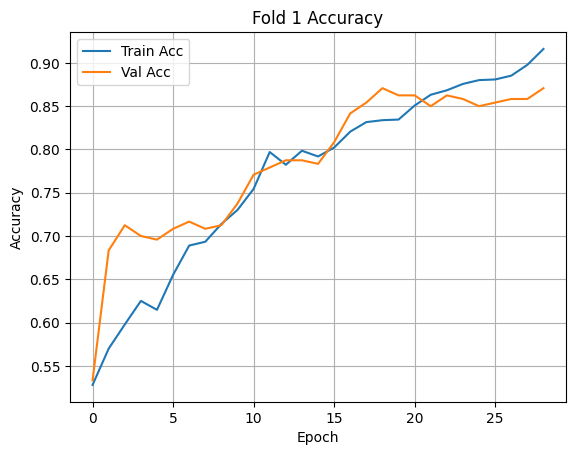

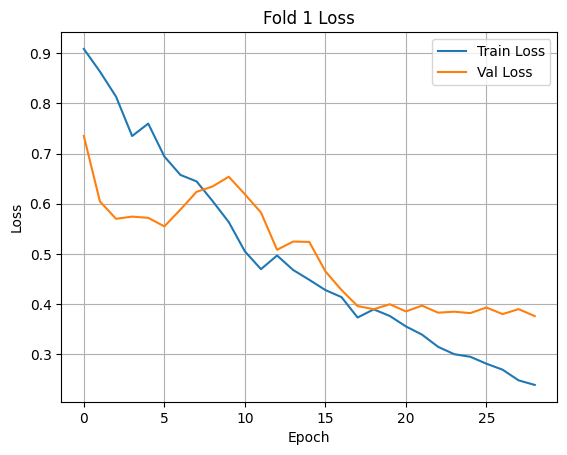

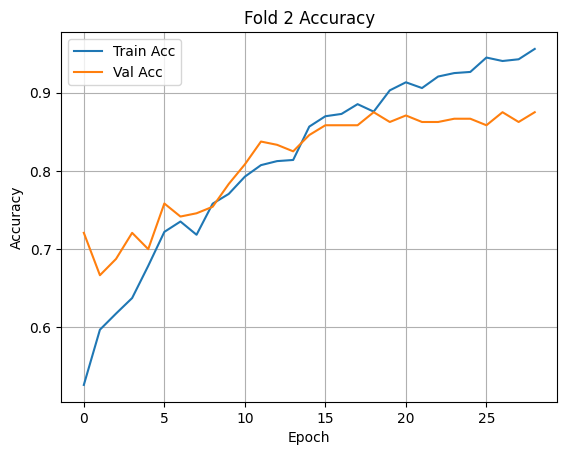

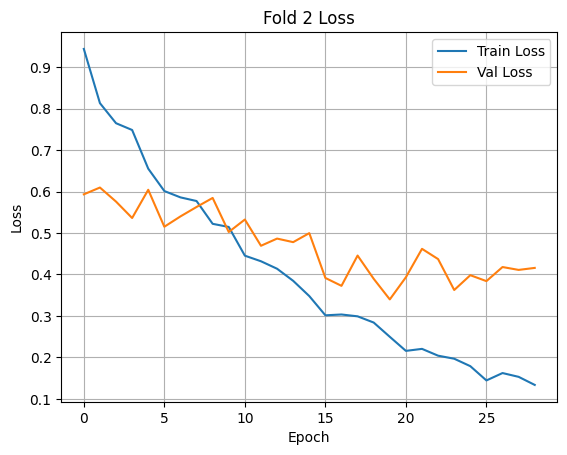

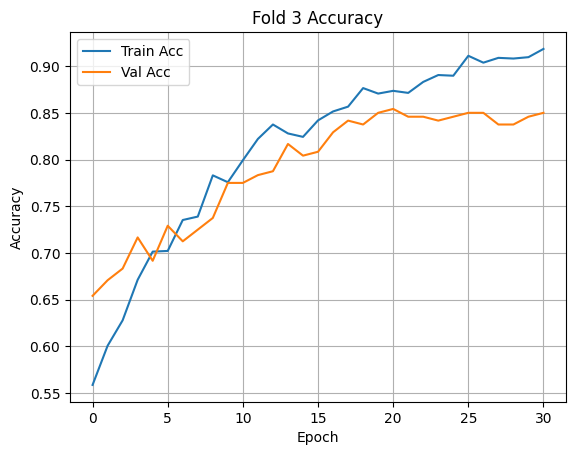

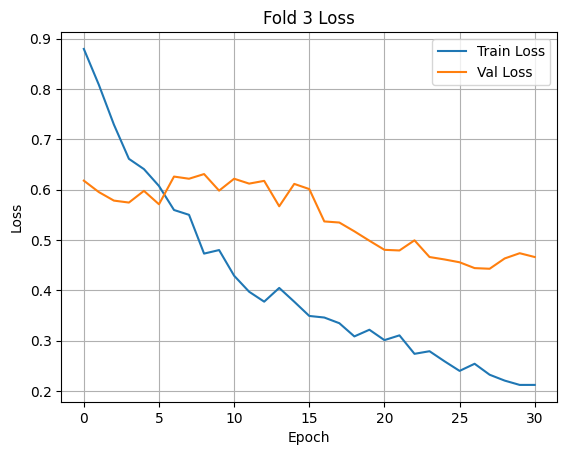

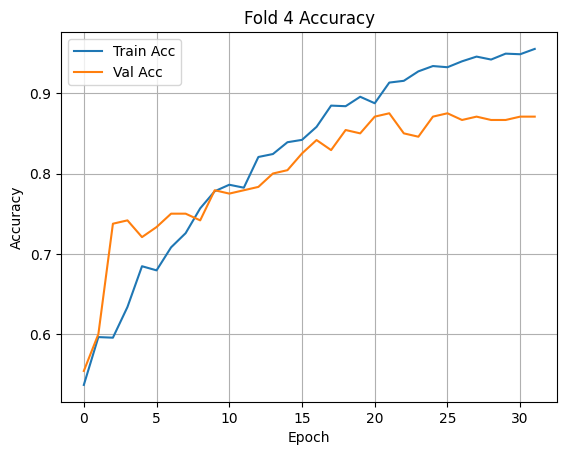

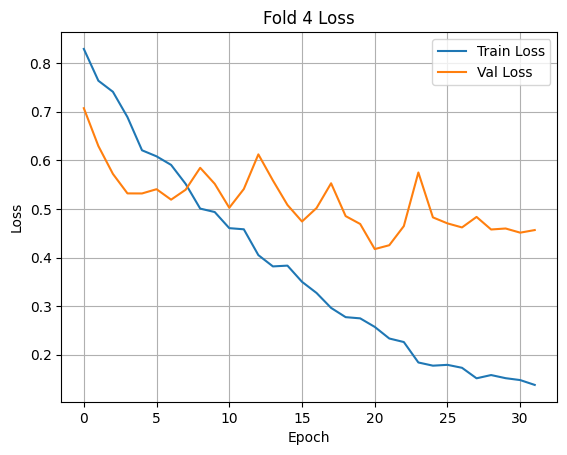

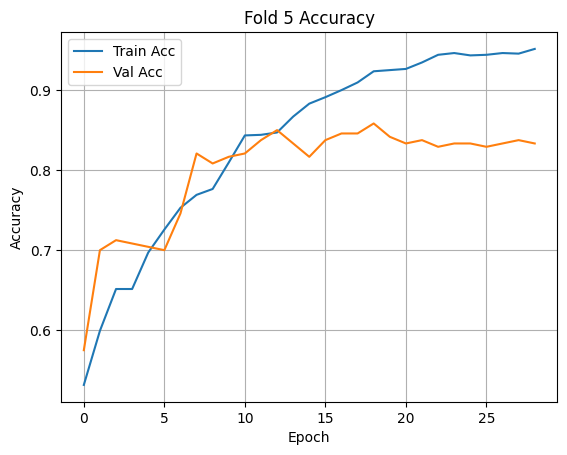

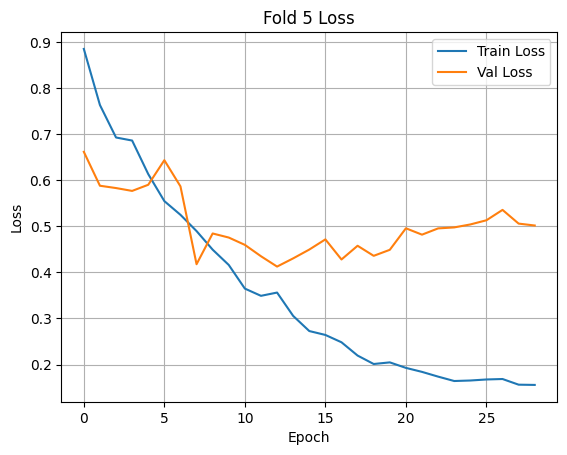

In [15]:
for i, hist in enumerate(all_histories, 1):
    plt.figure()
    plt.plot(hist['accuracy'], label='Train Acc')
    plt.plot(hist['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {i} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.title(f'Fold {i} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [16]:
# Save mô hình fold cuối cùng
model.save("TCN_TemporalConvNet_Residual Blocks_final.h5")

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df

📊 Kết quả trung bình:
fold         3.000000
accuracy     0.841000
precision    0.788858
recall       0.932000
f1           0.854201
auc          0.934755
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.8450,0.797414,0.925,0.856481,0.933750
1,2,0.8600,0.813043,0.935,0.869767,0.943375
2,3,0.8100,0.769565,0.885,0.823256,0.901300
3,4,0.8525,0.797468,0.945,0.864989,0.950125
4,5,0.8375,0.766798,0.970,0.856512,0.945225


In [18]:
import pandas as pd

# Giả sử results đã có và bạn đã tạo results_df
results_df = pd.DataFrame(results)

# Tính các chỉ số
accuracy_mean = results_df['accuracy'].mean()
accuracy_std = results_df['accuracy'].std()  # dùng sample std (chia cho n-1)
accuracy_range = results_df['accuracy'].max() - results_df['accuracy'].min()
accuracy_cv_percent = (accuracy_std / accuracy_mean) * 100

# In kết quả
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))

print(f"\n✅ CV Accuracy (Mean Accuracy): {accuracy_mean:.4f}")
print(f"📈 Range Accuracy: {accuracy_range:.4f}")
print(f"📉 Accuracy CV% (std/mean): {accuracy_cv_percent:.2f}%")

# Hiển thị bảng kết quả nếu cần
results_df

📊 Kết quả trung bình:
fold         3.000000
accuracy     0.841000
precision    0.788858
recall       0.932000
f1           0.854201
auc          0.934755
dtype: float64

✅ CV Accuracy (Mean Accuracy): 0.8410
📈 Range Accuracy: 0.0500
📉 Accuracy CV% (std/mean): 2.29%


,fold,accuracy,precision,recall,f1,auc
0,1,0.8450,0.797414,0.925,0.856481,0.933750
1,2,0.8600,0.813043,0.935,0.869767,0.943375
2,3,0.8100,0.769565,0.885,0.823256,0.901300
3,4,0.8525,0.797468,0.945,0.864989,0.950125
4,5,0.8375,0.766798,0.970,0.856512,0.945225
